In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision
from torchvision import transforms, datasets
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from tqdm import tqdm

##  (a) Dataloader

1) Load the npy files using np.load.
2) Split the data for training and validation (80% for training and 20 % for splitting) using train_test_split
3) Reshape the data to fit CNN input requirements.
4) Convert the reshaped numpy arrays to PyTorch tensors for model input using torch.tensor function
5) Create a dataset combining the data and labels for training using TensorDataset function
6) Create a DataLoader for batching and shuffling during training using DataLoader function

In [2]:
# Load data and labels
x_train = np.load('/kaggle/input/hw4-data/x_train/x_train.npy')
y_train = np.load('/kaggle/input/hw4-data/y_train.npy')

#split the data for training and Validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state =1234)
print("Shape of x_train:", x_train.shape)

#Reshape the data
x_train = x_train.reshape(-1, 1, 28, 28)
x_val = x_val.reshape(-1, 1, 28, 28)

# Convert to tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create a dataset with both data and labels
dataset = TensorDataset(x_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Load a single batch from the dataloader
images, labels = next(iter(dataloader))

# Check the shape of a batch of images from the dataloader
print(images.shape)

Shape of x_train: (48000, 784)
torch.Size([64, 1, 28, 28])


## (b) Data Exploration

The below code visualizes the first occurrence of each digit (from 0 to 9) in a batch of images from dataloader.
1. Initialize Digits Set and Counter j. The Counter j is used for subplots for position in 2x5 grid.
2. Iterate Over the DataLoader
3. If the Digit is already used, continue. Else add the digit to the set and plot the image.
4. Loop until all the digits are plotted.

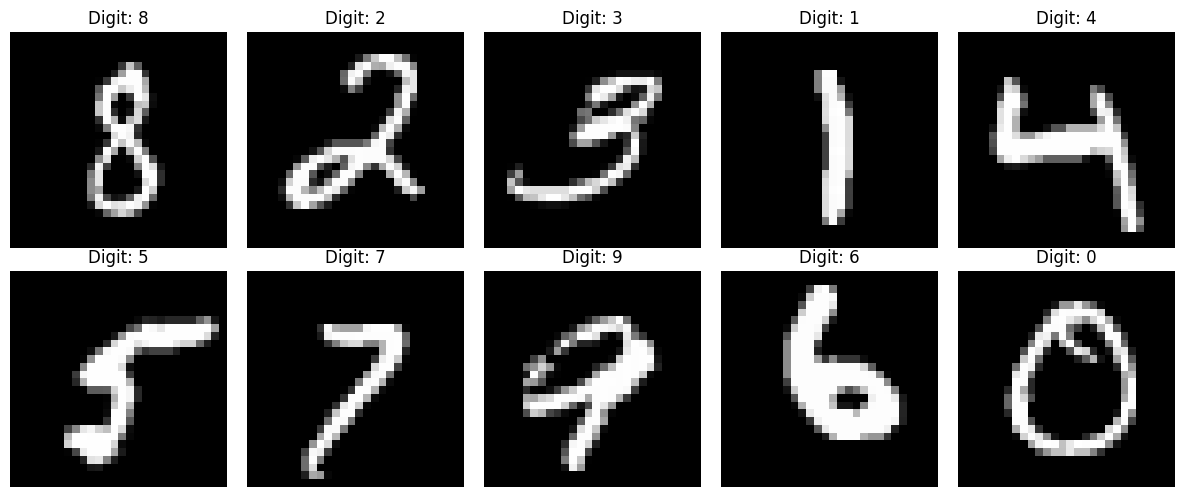

In [3]:
# Initialize a set and counter
Digits = set()
j = 0
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

#Iterate Over the DataLoader
for images, labels in dataloader:
    #Loop until all the digits are plotted.
    if(len(Digits) == 10):
        break
    for i in range(len(labels)):
        label = labels[i].item()
        if label not in Digits:
            Digits.add(label)
            image = images[i].view(28, 28)
            ax = axes[j // 5, j % 5]  # Position in 2x5 grid
            ax.imshow(image, cmap='gray')
            ax.set_title(f"Digit: {label}")
            ax.axis('off')
            j = j + 1
plt.tight_layout()
plt.show()

 The below count the  number of samples per digit in th training dataa
 1. The numpy.unique() function finds the unique elements of y_train..

In [4]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts)) #zip() function is used to combine multiple iterables

{0: 4732,
 1: 5375,
 2: 4737,
 3: 4873,
 4: 4718,
 5: 4346,
 6: 4731,
 7: 5038,
 8: 4672,
 9: 4778}

##  (c) Modeling

The below code defines a custom CNN block that will be used in final neural network model. The block consists of two convolutional layers with batch normalization. Based on activation function which is passed through parameter the class uses either RELU or Sigmoid. This is done to use during Hyperparameter tuning.

Parameters:
1. in_channels: Number of input channels (1 for grayscale images, 3 for RGB images)
2. n_hidden: Number of output channels in the convolutional layer.
3. kernel_size: Size of the filter
4. activation_func: activation function that will be used for CNN
5. Dropout: Dropout probability to prevent overfitting. (0.5 means 50 %)
6. stride: Step size for moving the filter across the input.

REF: Week 11 Discussion 9 - CNN

In [5]:
class cnn_block(nn.Module):
  def __init__(self, in_channels = 3, n_hidden = 5, kernel_size = (2, 2), activation_func = 'RELU', Dropout = 0.5, stride = 1):
    super().__init__()
    if(activation_func == 'RELU'):
        # Define a sequence of layers with ReLU activation
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = n_hidden, kernel_size = kernel_size, bias=False, padding = 'same', stride = stride),
            nn.BatchNorm2d(num_features = n_hidden),
            nn.ReLU(),
            nn.Dropout(p=Dropout),
            nn.Conv2d(in_channels = n_hidden, out_channels = in_channels, kernel_size = kernel_size, bias=False, padding = 'same', stride = stride),
            nn.BatchNorm2d(num_features = in_channels),
            nn.ReLU(),
            nn.Dropout(p=Dropout))
    else:
        # Define a sequence of layers with Sigmoid activation
       self.layers = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = n_hidden, kernel_size = kernel_size, bias=False, padding = 'same', stride = stride),
            nn.BatchNorm2d(num_features = n_hidden),
            nn.Sigmoid(),
            nn.Dropout(p=Dropout),
            nn.Conv2d(in_channels = n_hidden, out_channels = in_channels, kernel_size = kernel_size, bias=False, padding = 'same', stride = stride),
            nn.BatchNorm2d(num_features = in_channels),
            nn.Sigmoid(),
            nn.Dropout(p=Dropout)) 

  def forward(self, x):
    return x + self.layers(x)

The below class defines fully connected (linear) block with two linear layers, each followed by an activation function and dropout. This class will be used in final neural network model. Based on activation function which is passed through parameter the class uses either RELU or Sigmoid. This is done to use during Hyperparameter tuning.

Parameters:

1. in_features: number of input features.
2. n_hidden: number of hidden units in the intermediate layer.
3. activation_func: activation function that will be used in linear model
4. Dropout: Dropout probability to prevent overfitting. (0.5 means 50 %)

In [6]:
class linear_block(nn.Module):
  def __init__(self, in_features, n_hidden, activation_func = 'RELU', Dropout = 0.5):
    super().__init__()
    self.in_features = (in_features, n_hidden, activation_func, Dropout)
    if(activation_func == 'RELU'):
        # Define layers with ReLU activation
        self.layers = nn.Sequential(
            nn.Linear(in_features = in_features, out_features = n_hidden),
            nn.ReLU(),
            nn.Dropout(p=Dropout),
            nn.Linear(in_features = n_hidden, out_features = in_features),
            nn.ReLU()
        )
    else:
        # Define layers with Sigmoid activation
        self.layers = nn.Sequential(
            nn.Linear(in_features = in_features, out_features = n_hidden),
            nn.Sigmoid(),
            nn.Dropout(p=Dropout),
            nn.Linear(in_features = n_hidden, out_features = in_features),
            nn.Sigmoid()
        )

  def forward(self, x):
    return x + self.layers(x)

The below class combines convolutional and fully connected linear layers. The class defines a convolutional neural network (CNN) architecture with multiple layers.

In [7]:
class CNNClassifier(nn.Module):
  def __init__(self, in_channels = 3, cnn_channels = 3, linear_hidden = 1000, n_classes = 3, kernel_size = (2, 2), activation_func = 'RELU', Dropout = 0.5, stride = 1):
    super().__init__()
    #Convolutional layers
    self.cnn_layers = nn.Sequential(
        cnn_block(in_channels, cnn_channels, kernel_size, activation_func, Dropout, stride),
        cnn_block(in_channels, cnn_channels, kernel_size, activation_func, Dropout, stride),
        cnn_block(in_channels, cnn_channels, kernel_size, activation_func, Dropout, stride))

    self.down_sample = nn.Conv2d(in_channels = in_channels, out_channels = 1, kernel_size = (1, 1))
      
    #fully connected linear layers
    self.linear_layers = nn.Sequential(
        linear_block(28*28, linear_hidden, activation_func, Dropout),
        linear_block(28*28, linear_hidden, activation_func, Dropout)
    )
    #final linear layer that gives output
    self.last_layer = nn.Linear(28*28, n_classes)

    # Combine all layers into a single sequential block
    self.all        = nn.Sequential(
        self.cnn_layers,
        self.down_sample,
        nn.Flatten(),
        self.linear_layers,
        self.last_layer,
    )

  def forward(self, x):
    return self.all(x)

The trainModel function trains a deep learning model over multiple epochs using a training dataset and evaluates it using a validation dataset.

Steps:
1. Create Lists to store loss and accuracy values per epoch
2. Loop over each epoch
3. Set model to training mode
4. Iterate over batches in the training DataLoader
5. Get predictions from the model
6. Compute loss between predictions and actual labels
7. Backpropogation
8. After finishing the iteration over batches, set the model to evaluation mode.
9. Iterate over batches in the validation DataLoader
10. Get predictions from the model and compute accuracy.
11. store the loss and accuracy values

In [8]:
def trainModel(n_epochs, model, train_dataloader, test_dataloader, device, optimizer):
    
    train_loss, test_loss, all_accuracy = [], [], []
    
    for epoch in tqdm(range(n_epochs)):
    
        # do a loop over all training samples
        model.train() # telling the model we are training it as it needs to keep track of gradients (and other things) in this modality
        epoch_train_loss = []
        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            preds = model(X)
    
            loss = loss_fn(preds, y)
    
            optimizer.zero_grad() # Clear previous gradients
            loss.backward() # Compute gradients
            optimizer.step() # Update model parameters
    
            epoch_train_loss.append(loss.item())
    
        # do a loop over all testing samples
        model.eval() # telling the model we are evaluating it
        epoch_test_loss = []
        correct = 0
        total = 0
        with torch.no_grad(): # alternatively, torch.no_grad()
            for batch, (X, y) in enumerate(val_dataloader):
                X, y = X.to(device), y.to(device)
                preds = model(X)
                loss  = loss_fn(preds, y)
                epoch_test_loss.append(loss.item())
                _, predicted = torch.max(preds, 1)  # Get index of max probability (predicted class)
                total += y.size(0)               # Total samples in the batch
                correct += (predicted == y).sum().item()  # Sum correct predictions
    
        # Calculate overall accuracy
        accuracy = (correct / total) * 100
        all_accuracy.append(accuracy)
        train_loss.append(np.mean(epoch_train_loss))
        test_loss.append(np.mean(epoch_test_loss))
    print(f'Overall Accuracy: {accuracy:.2f}%')
    return train_loss, test_loss, all_accuracy   


## Visualize the filters

In [9]:
def Visulaize_filters(cnn_layer):
    index = [0,4]
    for n in index:
        filter = cnn_layer.layers[n].weight.data.cpu().numpy()
        # Get the number of filters in the first Conv2d layer
        num_filters = filter.shape[0]
        # Create an 8x4 grid layout for displaying the filters
        fig, axes = plt.subplots(8, 4, figsize=(8, 8))  # Adjusted figsize for larger display
        # Iterate over each filter and display it with labels
        for i in range(num_filters):
            row, col = divmod(i, 4)  # Determine row and column in the 8x4 grid
            ax = axes[row, col]
            ax.imshow(filter[i, 0, :, :], cmap='gray')  # Display a single filter in grayscale
            ax.axis('off')  # Turn off axes for cleaner display
            ax.set_title(f"Filter {i+1}")  # Add label for each filter
        # Hide any empty subplots if there are fewer than 32 filters
        for i in range(num_filters, 8 * 4):
            fig.delaxes(axes.flat[i])
        plt.tight_layout()
        plt.show()

Visualise filters for first CNN layer:


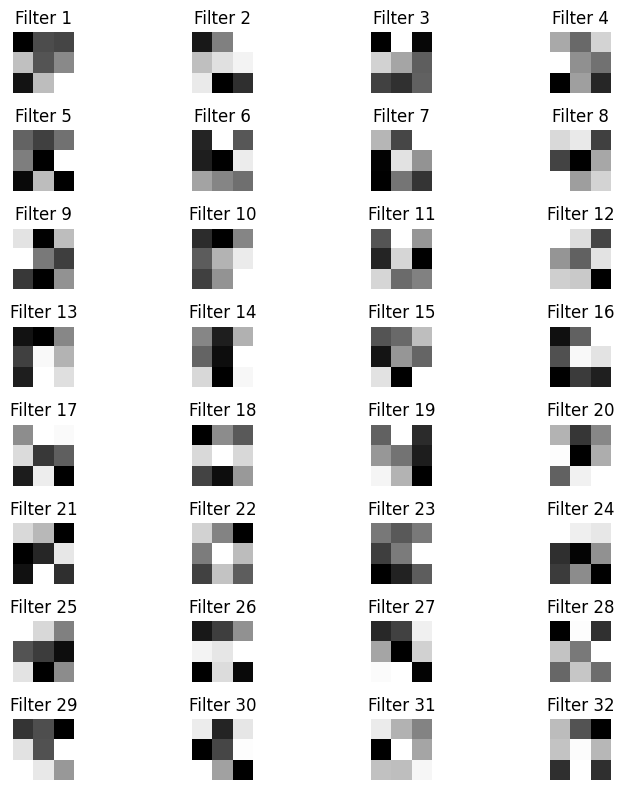

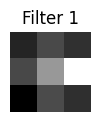

Visualise filters for Second CNN layer:


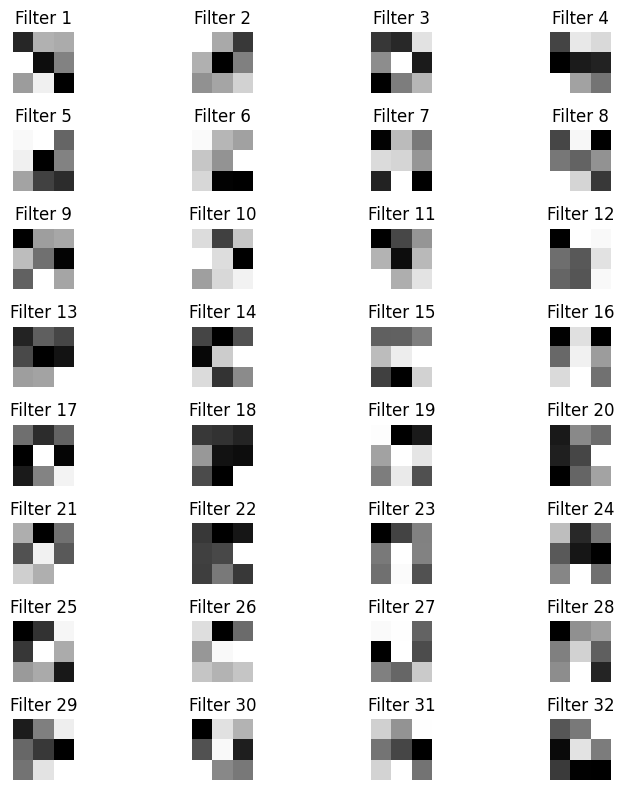

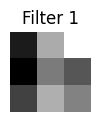

Visualise filters for Third CNN layer:


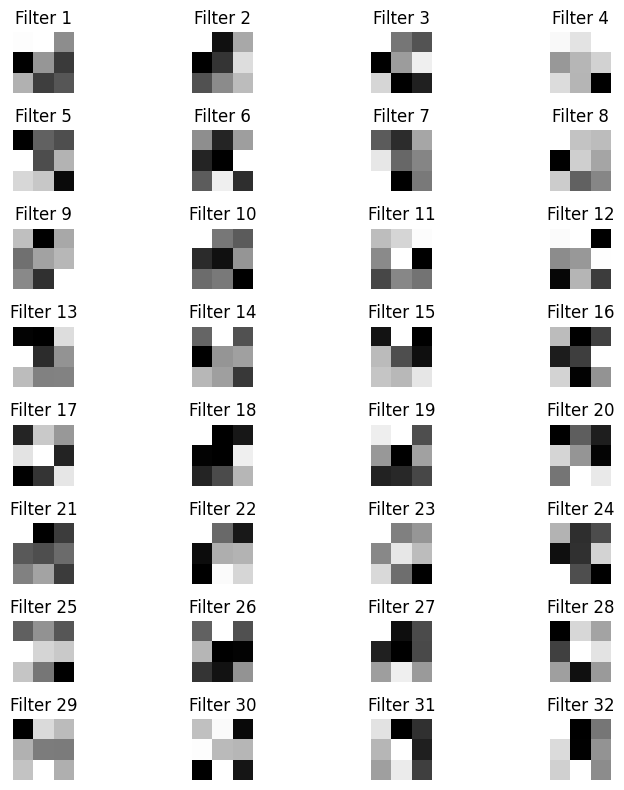

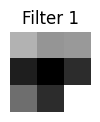

In [10]:
device    = 'cuda' if torch.cuda.is_available() else 'cpu'
model     = CNNClassifier(in_channels = 1, cnn_channels = 32, linear_hidden = 128, n_classes = 10, kernel_size = (3, 3), activation_func = 'RELU',Dropout = 0.5, stride = 1).to(device)
print('Visualise filters for first CNN layer:')
Visulaize_filters(model.cnn_layers[0])
print('Visualise filters for Second CNN layer:')
Visulaize_filters(model.cnn_layers[1])
print('Visualise filters for Third CNN layer:')
Visulaize_filters(model.cnn_layers[2])

In the below, I have taken combinations of number of layers, filter size, dropout values and learning rate and trained and validated the model. Out of the combinations, I am saving the best model which has predicted the validation set with highest accuracy.

100%|██████████| 50/50 [04:44<00:00,  5.70s/it]


Overall Accuracy: 98.05%


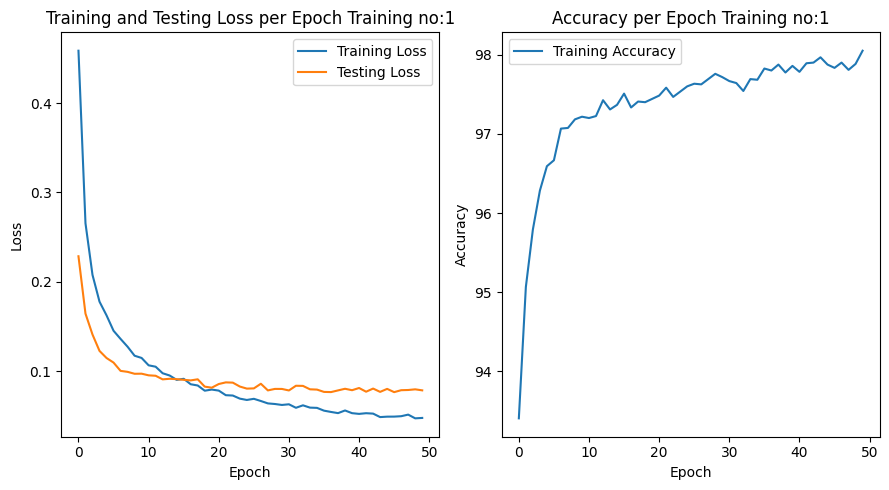

100%|██████████| 50/50 [04:41<00:00,  5.63s/it]


Overall Accuracy: 98.46%


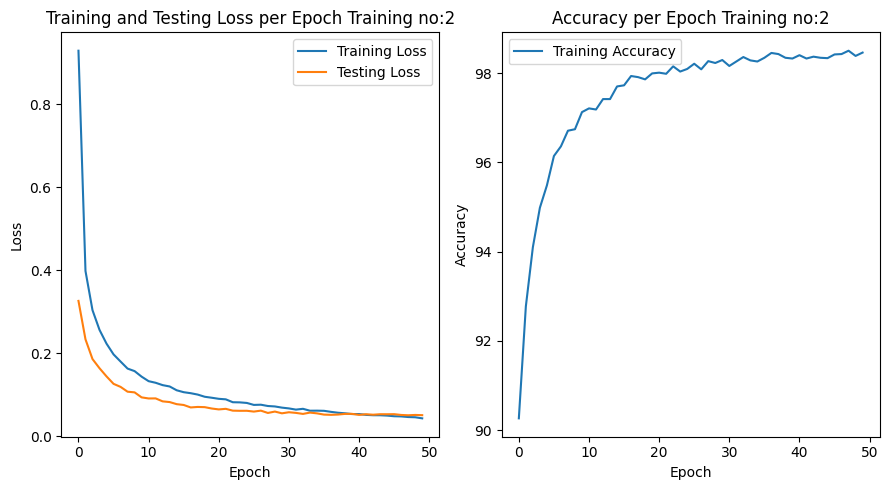

100%|██████████| 50/50 [04:41<00:00,  5.64s/it]


Overall Accuracy: 98.36%


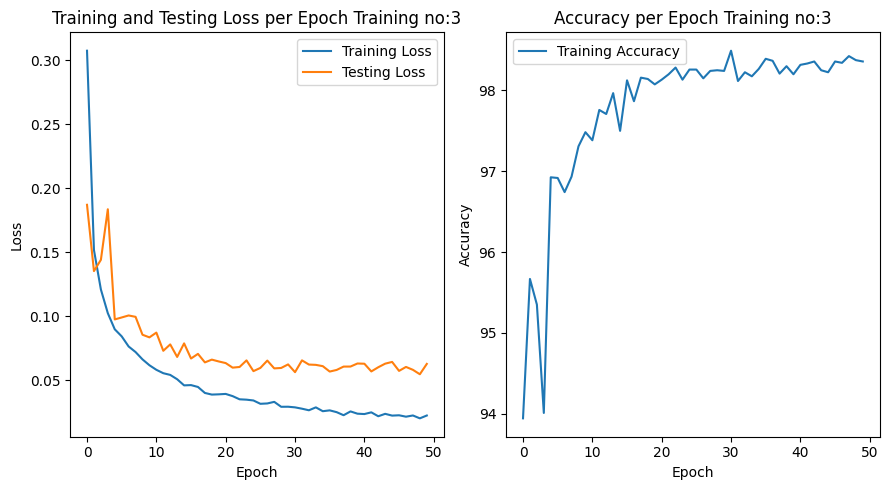

100%|██████████| 50/50 [04:40<00:00,  5.61s/it]


Overall Accuracy: 98.60%


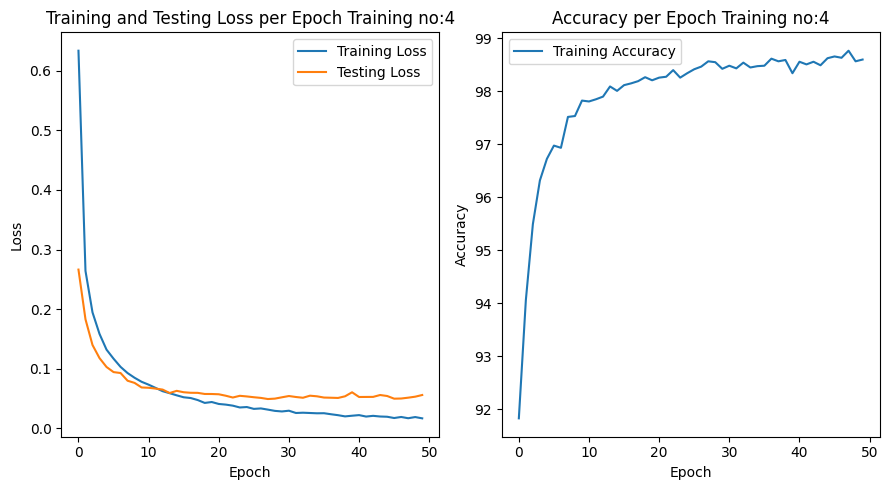

100%|██████████| 50/50 [04:31<00:00,  5.43s/it]


Overall Accuracy: 98.24%


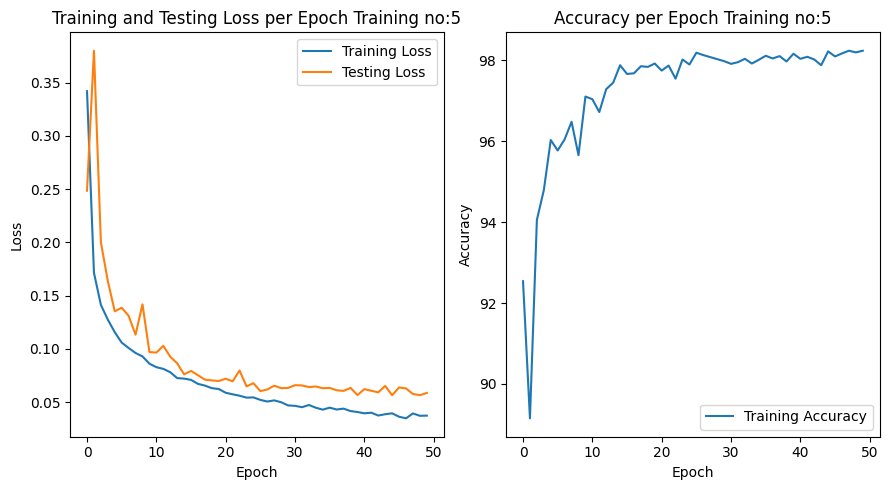

100%|██████████| 50/50 [04:33<00:00,  5.47s/it]


Overall Accuracy: 93.22%


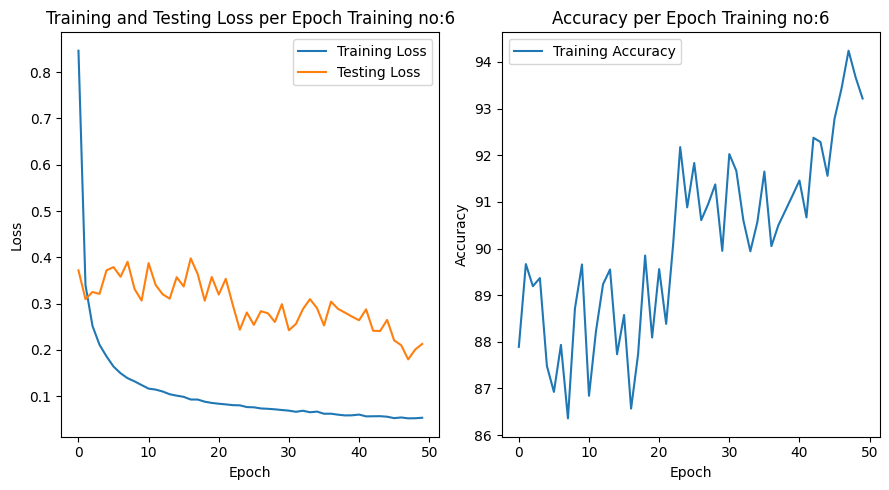

100%|██████████| 50/50 [04:33<00:00,  5.48s/it]


Overall Accuracy: 97.41%


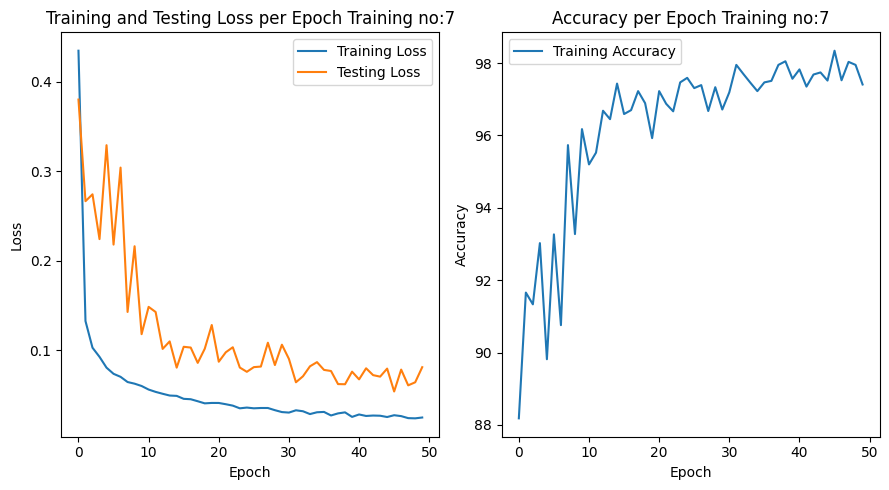

100%|██████████| 50/50 [04:32<00:00,  5.45s/it]


Overall Accuracy: 98.62%


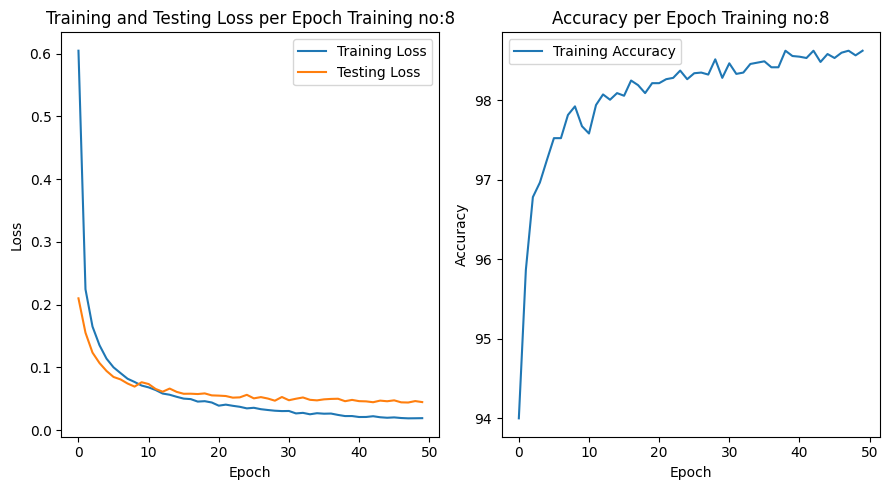

100%|██████████| 50/50 [04:47<00:00,  5.75s/it]


Overall Accuracy: 98.47%


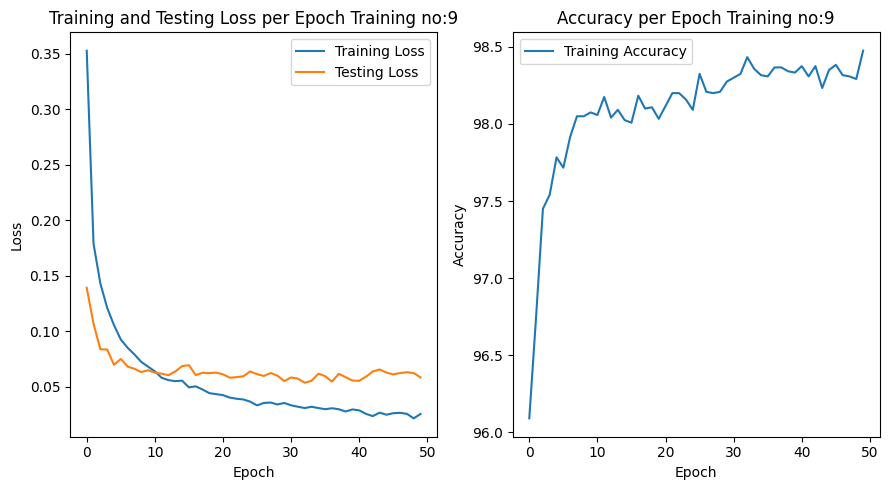

100%|██████████| 50/50 [04:44<00:00,  5.69s/it]


Overall Accuracy: 98.70%


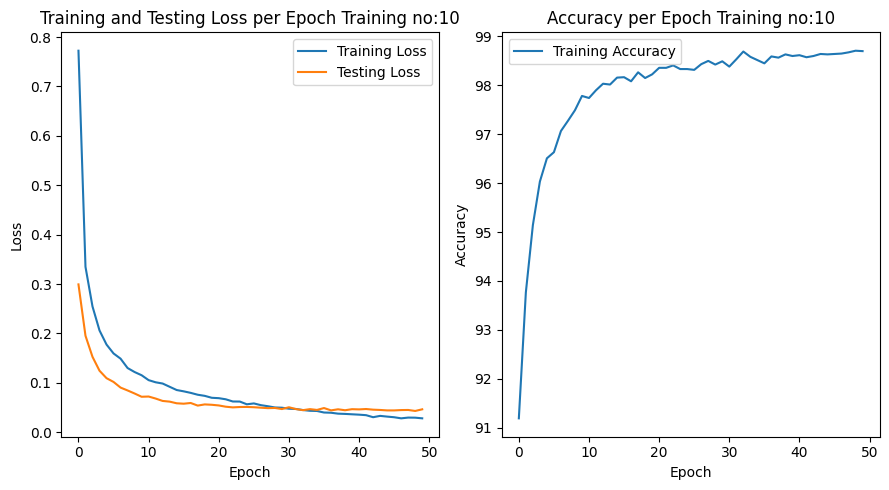

100%|██████████| 50/50 [04:45<00:00,  5.71s/it]


Overall Accuracy: 98.54%


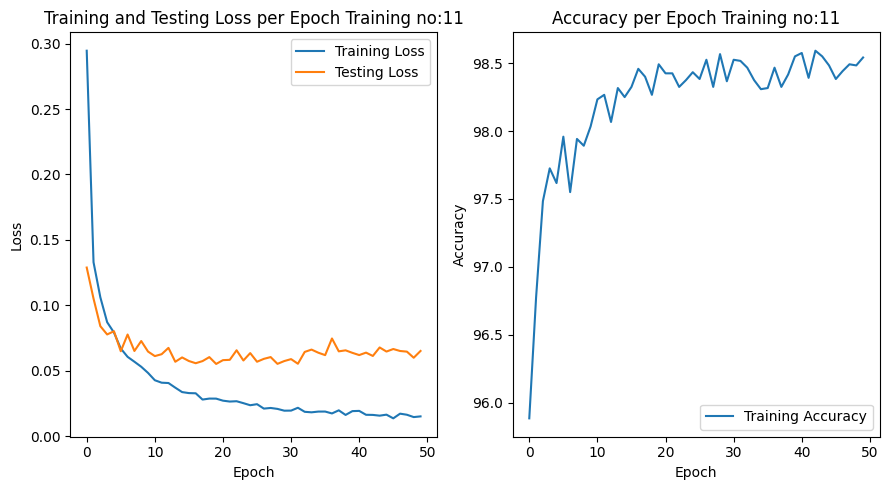

100%|██████████| 50/50 [04:46<00:00,  5.73s/it]


Overall Accuracy: 98.55%


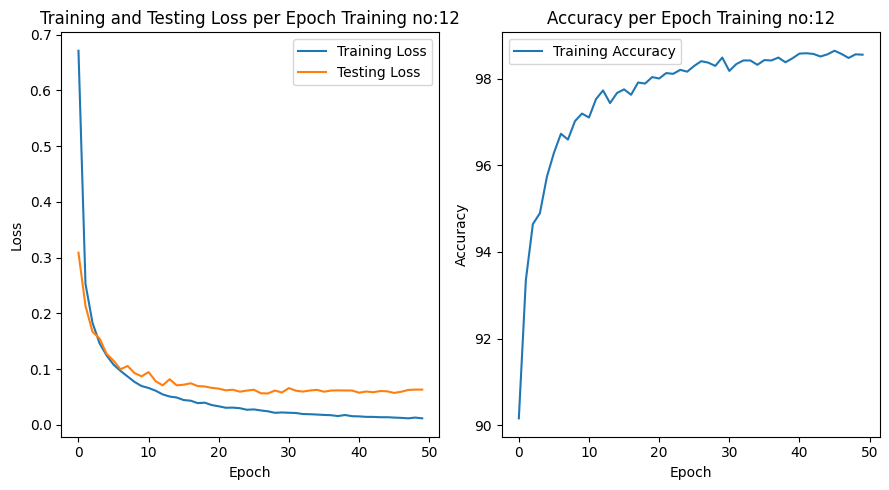

100%|██████████| 50/50 [04:34<00:00,  5.49s/it]


Overall Accuracy: 97.02%


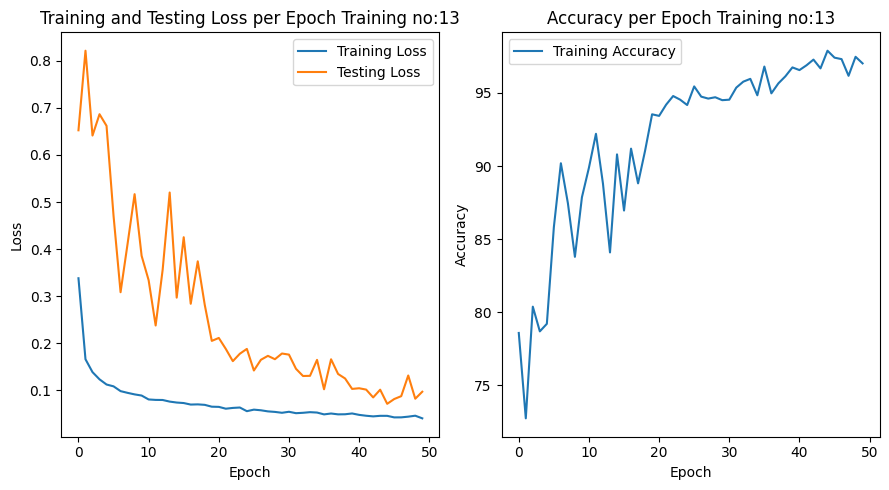

100%|██████████| 50/50 [04:33<00:00,  5.46s/it]


Overall Accuracy: 92.38%


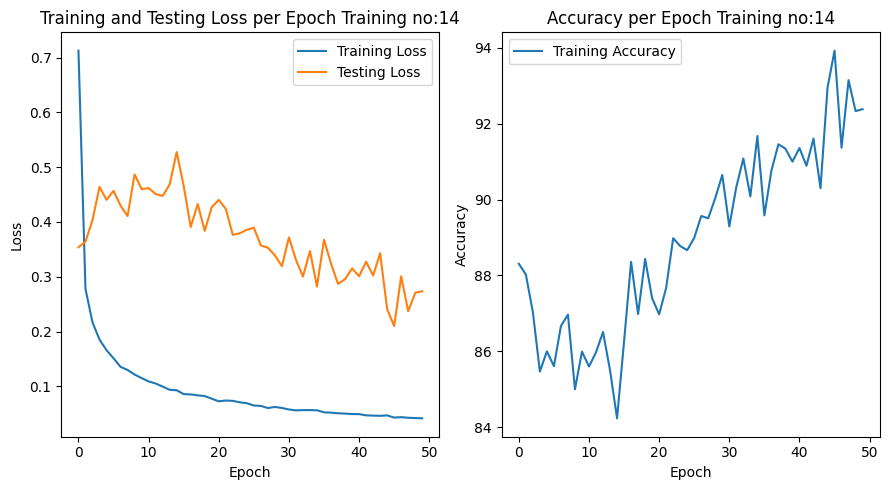

100%|██████████| 50/50 [04:34<00:00,  5.50s/it]


Overall Accuracy: 98.72%


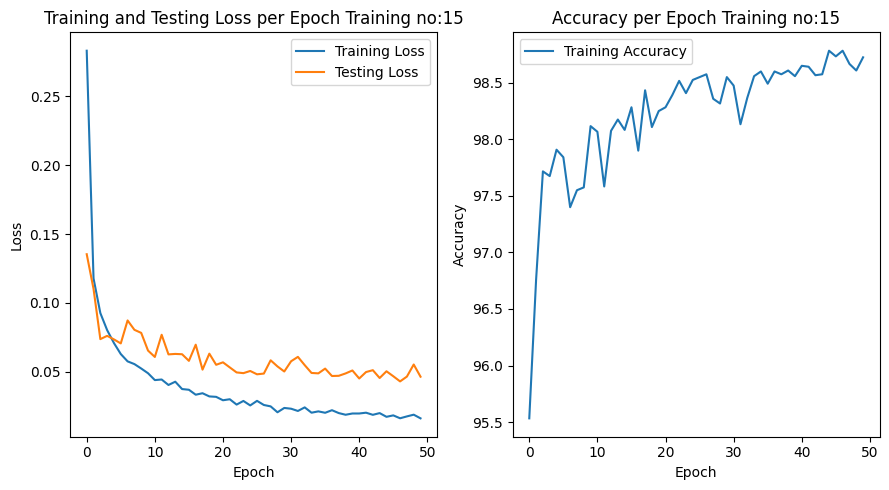

100%|██████████| 50/50 [04:33<00:00,  5.47s/it]


Overall Accuracy: 98.70%


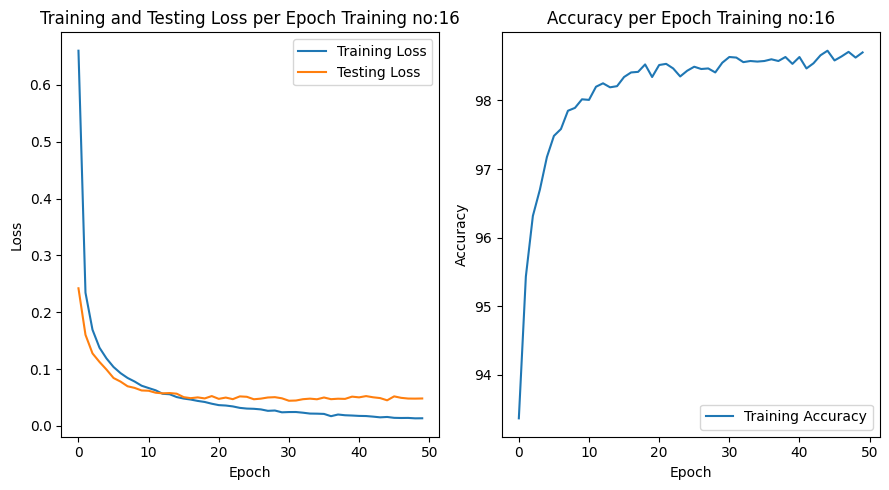

Overall best_Accuracy: 98.72%
Best model num_layers 256
Best model filter_size 5
Best model dropout_val 0.3
Best model learning rate 0.001


In [11]:
from torch.optim import Adam
from torch.optim import SGD

num_layers_list = [128, 256]
filter_size_list = [3,5]
stride_list = [1,2]
activation_function_list = ['RELU', 'SIGMOID']
dropout_list = [0.5, 0.3]
weight_decay_list = [0, 1e-5]
loss_fun_list = ['CEL', 'MSE']
optim_list = ['ADAM', 'SGD']
lr_list = [1e-3, 1e-4]
best_accuracy = 0
best_hyperparameter_comb = {
    'num_layers': 0,
    'filter_size': 0,
    'dropout_val': 0,
    'lr': 0
}
i = 0
device    = 'cuda' if torch.cuda.is_available() else 'cpu'
for num_layers in num_layers_list:
    for filter_size in filter_size_list:
        for dropout_val in dropout_list:
            for lr in lr_list:
                model     = CNNClassifier(in_channels = 1, cnn_channels = 32, linear_hidden = num_layers, n_classes = 10, kernel_size = (filter_size, filter_size), activation_func = 'RELU',Dropout = dropout_val, stride = 1).to(device)
                loss_fn   = nn.CrossEntropyLoss()
                optimizer = Adam(model.parameters(), lr = lr)
                
                train_loss, test_loss, all_accuracy = trainModel(50, model, dataloader, val_dataloader, device, optimizer)
                # Create a figure with two subplots
                fig, axes = plt.subplots(1, 2, figsize=(9, 5))
                i = i + 1
                # Plot Training and Testing Loss on the first subplot
                axes[0].plot(train_loss, label='Training Loss')
                axes[0].plot(test_loss, label='Testing Loss')
                axes[0].set_xlabel('Epoch')
                axes[0].set_ylabel('Loss')
                axes[0].legend()
                axes[0].set_title(f'Training and Testing Loss per Epoch Training no:{i}')
                
                # Plot Accuracy on the second subplot
                axes[1].plot(all_accuracy, label='Training Accuracy')
                axes[1].set_xlabel('Epoch')
                axes[1].set_ylabel('Accuracy')
                axes[1].legend()
                axes[1].set_title(f'Accuracy per Epoch Training no:{i}')
                
                # Display the plots
                plt.tight_layout()
                plt.show()
                if(all_accuracy[-1] > best_accuracy):
                    best_accuracy = all_accuracy[-1]
                    best_hyperparameter_comb['num_layers'] = num_layers
                    best_hyperparameter_comb['filter_size'] = filter_size
                    best_hyperparameter_comb['dropout_val'] = dropout_val
                    best_hyperparameter_comb['lr'] = lr
                    best_model = model
print(f'Overall best_Accuracy: {best_accuracy:.2f}%')
print('Best model num_layers', best_hyperparameter_comb['num_layers'])
print('Best model filter_size', best_hyperparameter_comb['filter_size'])
print('Best model dropout_val', best_hyperparameter_comb['dropout_val'])
print('Best model learning rate', best_hyperparameter_comb['lr'])

From the above results, it can be observed that the best accuracy has been achieved with the combination of number of layers 256, filter size (5,5), Dropu out value is 0.3 (30%) and learning rate is 0.01. The accuracy value is 98.72%

100%|██████████| 50/50 [04:32<00:00,  5.46s/it]


Overall Accuracy: 96.15%


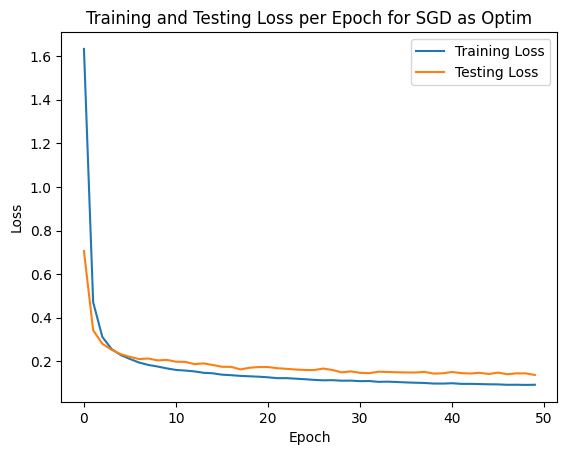

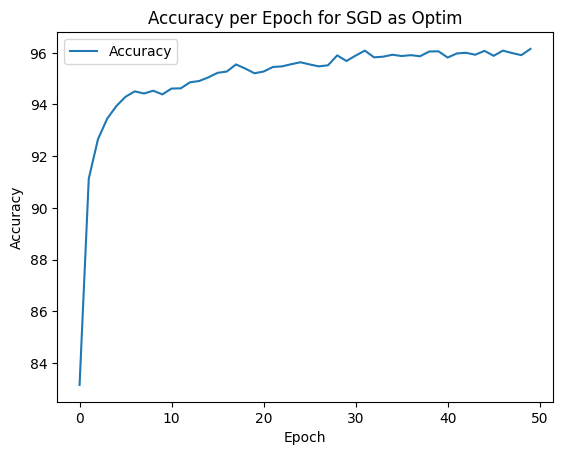

Overall Accuracy: 96.15%


In [15]:
from torch.optim import SGD
device    = 'cuda' if torch.cuda.is_available() else 'cpu'
model     = CNNClassifier(in_channels = 1, cnn_channels = 32, linear_hidden = best_hyperparameter_comb['num_layers'], n_classes = 10, kernel_size = (best_hyperparameter_comb['filter_size'], best_hyperparameter_comb['filter_size']), activation_func = 'RELU',Dropout = best_hyperparameter_comb['dropout_val'], stride = 1).to(device)
loss_fn   = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr = best_hyperparameter_comb['lr'])

train_loss, test_loss, all_accuracy = trainModel(50, model, dataloader, val_dataloader, device, optimizer)
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss per Epoch for SGD as Optim')
plt.show()


plt.plot(all_accuracy, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy per Epoch for SGD as Optim')
plt.show()
print(f'Overall Accuracy: {all_accuracy[-1]:.2f}%')

With the SGD as optimiser, it has been observed that overall accuracy is very much less compared to Adam as optimiser.

# Predictions for test data

The below code predicts the labels for the test data using best model found during hyperparamter tuning and save the predictions in the csv file.

In [16]:
import pandas as pd
x_test = np.load('/kaggle/input/hw4-data/x_test.npy')
x_test = x_test.reshape(-1, 1, 28, 28)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
dummy_labels = torch.zeros(x_test_tensor.size(0), dtype=torch.long)
# Create a dataset with both data and labels
testdataset = TensorDataset(x_test_tensor, dummy_labels)
testdataloader = DataLoader(testdataset, batch_size=64, shuffle=False)
best_model.to(device)
best_model.eval()
# Initialize an empty list to store predictions
final_predictions = []

with torch.inference_mode():  # Inference mode for reduced memory usage
    for inputs, _ in testdataloader:  # Unpack tuple, ignore dummy labels
        inputs = inputs.to(device)  # Move inputs to device
        outputs = best_model(inputs)  # Forward pass through the model
        _, predicted = torch.max(outputs, 1)  # Get the predicted class labels
        final_predictions.extend(predicted.tolist())  # Append predictions to list

df_predictions = pd.DataFrame({"pred_cnn": final_predictions})
df_predictions.to_csv("SreedharReddy_Pacharla_Preds.csv", index=False)
print("Unique predictions found:", set(final_predictions))

Unique predictions found: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


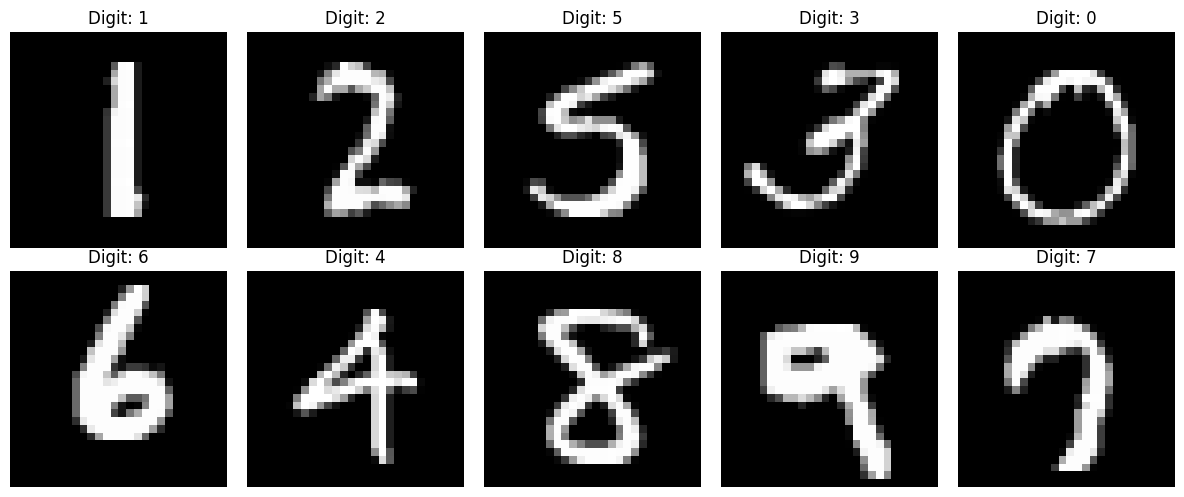

In [17]:
Digits = set()
j = 0
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
# Iterate through the images and predictions to plot the first 10 unique digits
index = 0  # Counter for accessing `final_predictions`
for images, _ in testdataloader:
    images = images.cpu()  # Move images to CPU for plotting
    if len(Digits) == 10:  # Stop when we have 10 unique digits
        break
    for i in range(len(images)):
        prediction = final_predictions[index]  # Access the correct prediction
        index += 1  # Move to the next prediction
        if prediction not in Digits:
            Digits.add(prediction)  # Add unique prediction to the set
            image = images[i].view(28, 28)
            ax = axes[j // 5, j % 5]  # Position in 2x5 grid
            ax.imshow(image, cmap='gray')
            ax.set_title(f"Digit: {prediction}")
            ax.axis('off')  # Hide the axes
            j += 1  # Only increment `j` when a unique digit is added

plt.tight_layout()
plt.show()

Visualise filters for  best model first CNN layer:


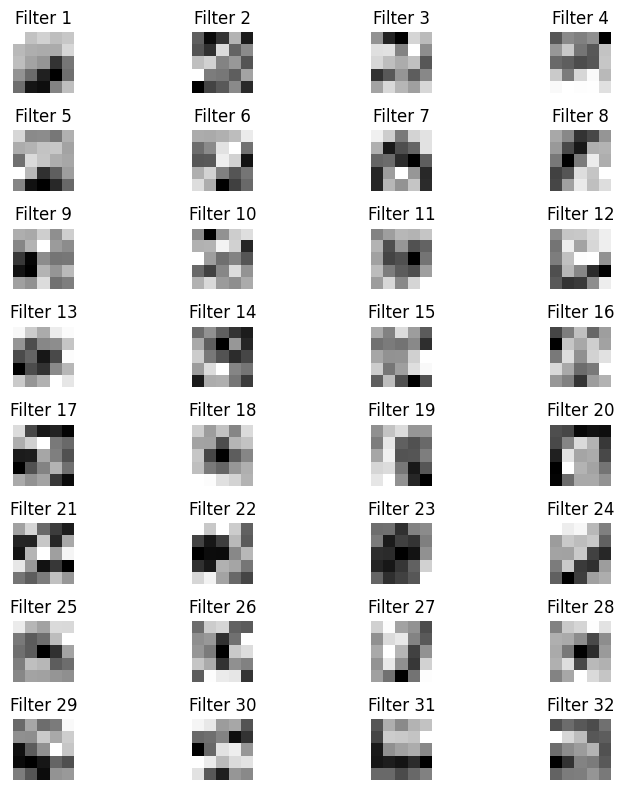

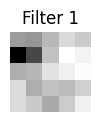

Visualise filters for best model Second CNN layer:


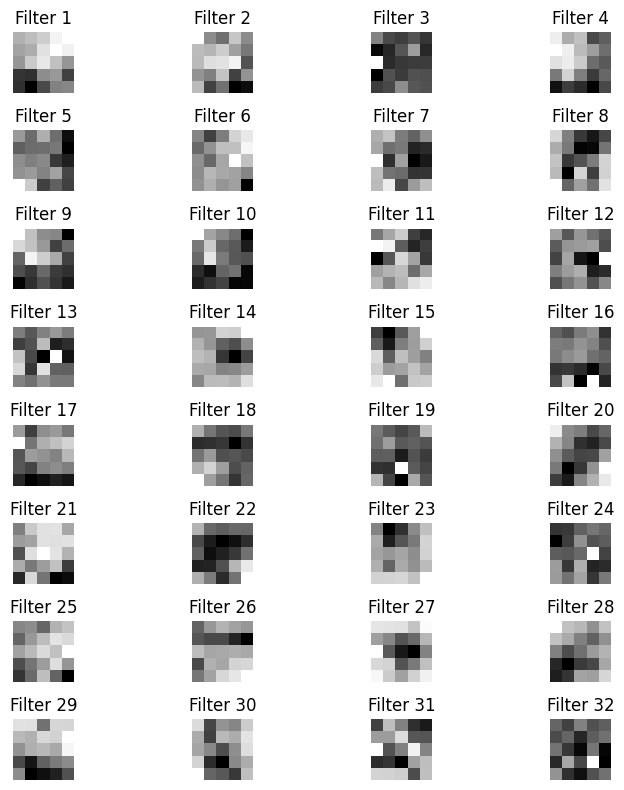

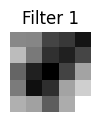

Visualise filters for best model Third CNN layer:


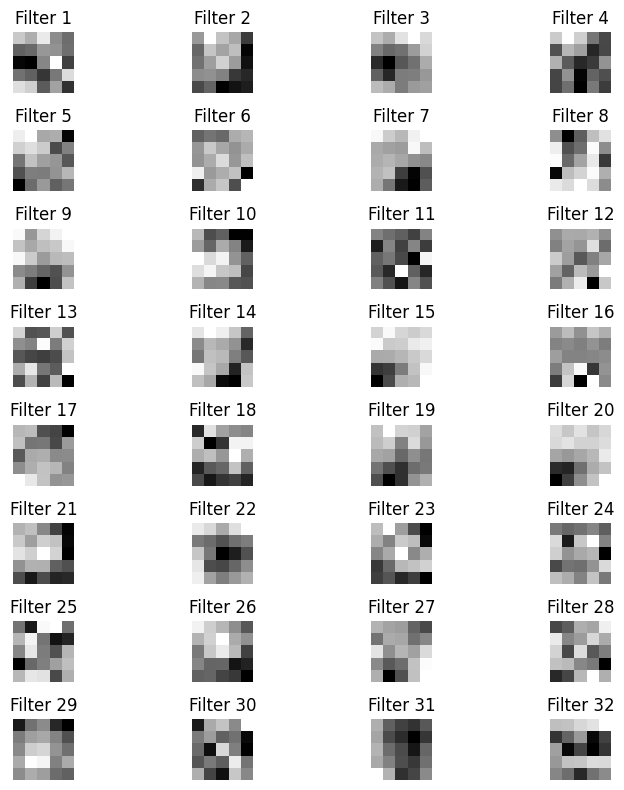

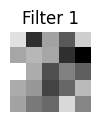

In [18]:
print('Visualise filters for  best model first CNN layer:')
Visulaize_filters(best_model.cnn_layers[0])
print('Visualise filters for best model Second CNN layer:')
Visulaize_filters(best_model.cnn_layers[1])
print('Visualise filters for best model Third CNN layer:')
Visulaize_filters(best_model.cnn_layers[2])